In [3]:
import json
import tqdm
import yaml

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

root_path = Path('../results/al_results/')
model_names = [
    'RES18_RAND_CIFAR10_10_', 'RES18_RAND_CIFAR10_100_', 'RES18_RAND_CIFAR10_1000_',
    'RES18_ENTR_CIFAR10_10_', 'RES18_ENTR_CIFAR10_100_', 'RES18_ENTR_CIFAR10_1000_'
]
metrics = ["test_acc1","test_prec","test_loss","test_nll","test_tce","test_mce"]

In [4]:
results = {mn:{} for mn in model_names}

for model_name in model_names:
    paths = sorted(list(root_path.glob(model_name+"*")))
    for path in tqdm.tqdm(paths):
        with open(path / 'results.json', 'r') as f:
            run_results = json.load(f)
        with open(path / '.hydra/config.yaml') as g:
            conf = yaml.load(g, Loader=yaml.FullLoader)

        results[model_name][path.stem[-1]] = {'results': run_results, 'args': conf}

100%|██████████| 4/4 [00:00<00:00, 14.86it/s]


In [5]:
avg_metrics = {mn:{
    metr:[] for metr in metrics
} for mn in model_names}
std = {mn:{
    metr:[] for metr in metrics
} for mn in model_names}

for mn, runs in results.items():
    for metric in metrics:
        all_values = []
        for seed, run in runs.items():
            history = run['results']
            values = []
            for cycle in history:
                values.append(cycle['test_stats'][metric])
            all_values.append(values)
        avg_metrics[mn][metric] = np.mean(np.array(all_values), axis=0)
        std[mn][metric] = np.std(np.array(all_values), axis=0)

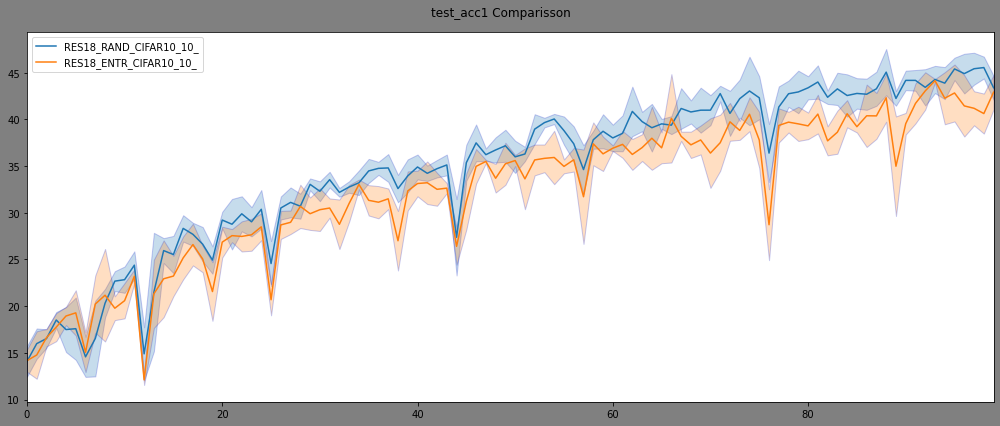

In [8]:
# Choice of Demonstration
model_A = 'RES18_RAND_CIFAR10_10_'
model_B = 'RES18_ENTR_CIFAR10_10_'
metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(14,6), facecolor='grey', edgecolor='black', tight_layout=True)
fig.suptitle(metric+' Comparisson')

for model in [model_A, model_B]:
    plt.plot(avg_metrics[model][metric], label=model)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(avg_metrics[model][metric]))], 
            y1=avg_metrics[model][metric]+abs(std[model][metric]), 
            y2=avg_metrics[model][metric]-abs(std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='upper left')
plt.xlim(0, len(avg_metrics[model_A][metric])-1)
plt.show()    

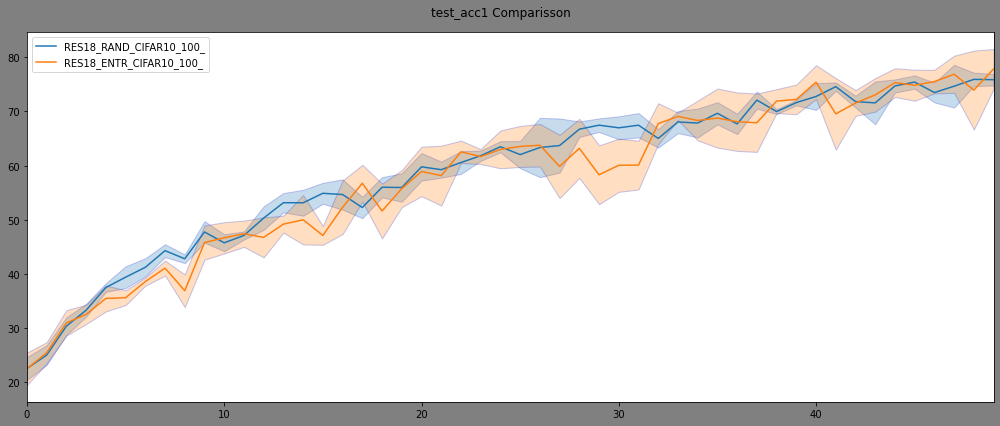

In [10]:
# Choice of Demonstration
model_A = 'RES18_RAND_CIFAR10_100_'
model_B = 'RES18_ENTR_CIFAR10_100_'
metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(14,6), facecolor='grey', edgecolor='black', tight_layout=True)
fig.suptitle(metric+' Comparisson')

for model in [model_A, model_B]:
    plt.plot(avg_metrics[model][metric], label=model)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(avg_metrics[model][metric]))], 
            y1=avg_metrics[model][metric]+abs(std[model][metric]), 
            y2=avg_metrics[model][metric]-abs(std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='upper left')
plt.xlim(0, len(avg_metrics[model_A][metric])-1)
plt.show()

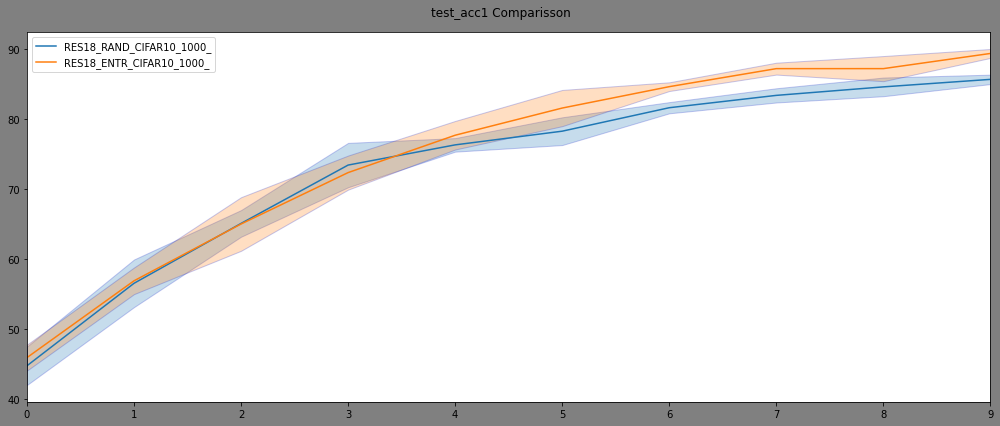

In [11]:
# Choice of Demonstration
model_A = 'RES18_RAND_CIFAR10_1000_'
model_B = 'RES18_ENTR_CIFAR10_1000_'
metric = 'test_acc1'
show_std = True

fig = plt.figure(figsize=(14,6), facecolor='grey', edgecolor='black', tight_layout=True)
fig.suptitle(metric+' Comparisson')

for model in [model_A, model_B]:
    plt.plot(avg_metrics[model][metric], label=model)
    if show_std:
        plt.fill_between(
            x=[i for i in range(len(avg_metrics[model][metric]))], 
            y1=avg_metrics[model][metric]+abs(std[model][metric]), 
            y2=avg_metrics[model][metric]-abs(std[model][metric]),
            alpha=0.25,
            edgecolor='#1B2ACC', 
            )
plt.legend(loc='upper left')
plt.xlim(0, len(avg_metrics[model_A][metric])-1)
plt.show()    